在贝叶斯分析中，计算后验分布时经常涉及复杂的积分运算，比如
$$
P(\theta\mid x)=\frac{P(x\mid \theta)P(\theta)}{P(x)}
$$

我们的目标是计算后验分布$P(\theta\mid x)$，困难在于计算$P(x)$, 因为
$$
P(x) = \int P(x, \theta)d\theta
$$

我们可能会想到通过Monte Carlo来近似$P(x)$， 但仔细一想，这是不可能的，因为无法从上述积分式中sample出样本来。

我们可以构造一个Markov链来进行Monte Carlo近似，这称之为MCMC。下面以一个实际例子来说明如何进行MCMC。

首先，导入必要的模块。

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm

sns.set_style('white')
sns.set_context('talk')

np.random.seed(123)

生成20个正态随机数，而我们的目标是根据这20个随机数，估计均值$\mu$的后验分布$P(\mu\mid x)$

In [2]:
data = np.random.randn(20)

绘制这20个随机数的直方图

In [3]:
#为了显示matplotlib画出的图
%matplotlib inline

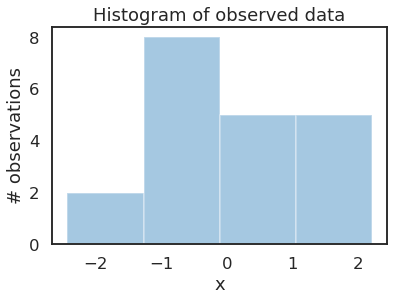

In [4]:
ax = plt.subplot()
sns.distplot(data, kde = False, ax = ax)
_ = ax.set(title='Histogram of observed data', xlabel='x', ylabel='# observations')

实际上，可以计算得到$\mu$理论上的后验分布。

In [12]:
## ###############################
## mu_0 prior
## sigma_0 prior
## sigma post    
## ###############################
def calc_posterior_analytical(data, x, mu_0, sigma_0):
    sigma = 1.
    n = len(data)
    mu_post = (mu_0/sigma_0**2 + data.sum()/sigma**2) / (1./sigma_0**2 + n/sigma**2)
    sigma_post = (1./sigma_0**2 + n/sigma**2)**-1
    return norm(mu_post, np.sqrt(sigma_post)).pdf(x)

In [45]:
mu_0 = 0
sigma_0 = 1
sigma = 1
n = len(data)
mu_post_true = (mu_0/sigma_0**2 + data.sum()/sigma**2) / (1./sigma_0**2 + n/sigma**2)
mu_post_true

0.10896926852884785

画出理论上的后验分布曲线

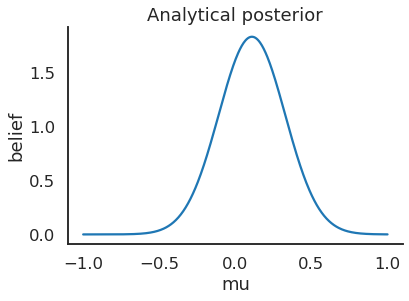

In [6]:
ax = plt.subplot()
x = np.linspace(-1, 1, 500)
posterior_analytical = calc_posterior_analytical(data, x, 0., 1.)
ax.plot(x, posterior_analytical)
ax.set(xlabel = 'mu', ylabel = 'belief', title='Analytical posterior')
sns.despine()

下面我们进行MCMC采样

In [7]:
def sampler(data, samples = 4, mu_init=.5, proposal_width = .5, plot=False, mu_prior_mu=0, mu_prior_sd=1.):
   mu_current = mu_init
   posterior = [mu_current]
   ll = []
   for i in range(samples):
       # sugget new position
       #
       # i-th state(xi) of markov: mu_current
       # proposal: sample from q(x|xi)
       # 
       # sample u from uniform(0, 1)
       # if u < alpha(xi, x) = min(p_proposal/p_current, 1)
       #     accept!!
       #
       mu_proposal = norm(mu_current, proposal_width).rvs() # random choose
       
       # Compute likelihood by multiplying probabilities of each data point
       likelihood_current = norm(mu_current, 1).pdf(data).prod()
       likelihood_proposal = norm(mu_proposal, 1).pdf(data).prod()
       
       # Compute prior probability of current and proposed mu 
       prior_current = norm(mu_prior_mu, mu_prior_sd).pdf(mu_current)
       prior_proposal = norm(mu_prior_mu, mu_prior_sd).pdf(mu_proposal)
       
       p_current = likelihood_current * prior_current
       p_proposal = likelihood_proposal * prior_proposal
       
       # Accept proposal?
       p_accept = p_proposal / p_current
       
       # Usually would include prior probability, which we neglect here for simplicity
       accept = np.random.rand() < p_accept

   #    if plot:
    #       plot_proposal(mu_current, mu_proposal, mu_prior_mu, mu_prior_sd, data, accept, posterior, i)
           
       if accept:
           mu_current = mu_proposal
           p_current = p_proposal
          
       posterior.append(mu_current)
       ll.append(p_current)
   return posterior, ll

进行5000次采样后的结果如下

In [8]:
posterior, ll = sampler(data, samples=5000, mu_init=.1, plot=False)

下面画出估计的后验分布的直方图

In [46]:
p_true = norm(mu_post_true, 1).pdf(data).prod() * norm(0, 1).pdf(mu_post_true)
p_true

1.2380707784151337e-15

In [47]:
np.log10(p_true)

-14.907254526724241

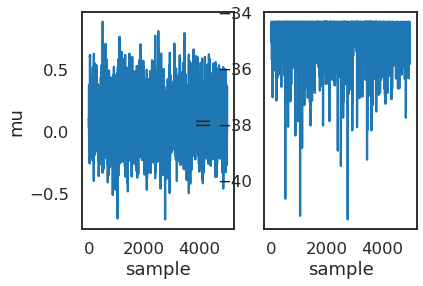

In [28]:
fig, ax = plt.subplots(1, 2)
ax[0].plot(posterior)
ax[1].plot(np.log(ll))
ax[1].hlines(np.log(p_true), 0, 4000)
_ = ax[0].set(xlabel='sample', ylabel='mu')
_ = ax[1].set(xlabel='sample', ylabel='ll')

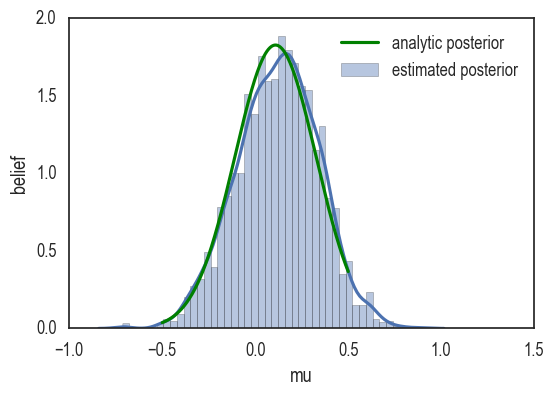

In [12]:
ax = plt.subplot()

sns.distplot(posterior[500:], ax=ax, label='estimated posterior')

x = np.linspace(-.5, .5, 500)
post = calc_posterior_analytical(data, x, 0, 1)
ax.plot(x, post, 'g', label='analytic posterior')
_ = ax.set(xlabel='mu', ylabel='belief');
ax.legend();

下面分析proposal width的影响，太大则选出的$\mu$跳跃太大，太小搜索空间时太慢。

proposal width较小时

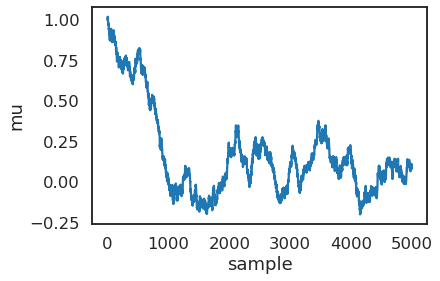

In [44]:
posterior_small, ll_small = sampler(data, samples=5000, mu_init=1., proposal_width=.01)
fig, ax = plt.subplots()
ax.plot(posterior_small);
_ = ax.set(xlabel='sample', ylabel='mu');

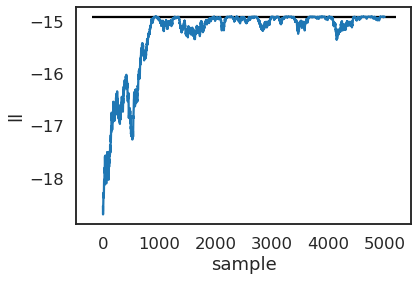

In [48]:
fig, ax = plt.subplots()
ax.hlines(np.log10(p_true), -200, len(ll_small)+200)
ax.plot(np.log10(ll_small)); plt.xlabel('sample'); plt.ylabel('ll');

In [68]:
def traceplot(mu, ll):
    plt.figure(figsize=(10, 6))
    plt.subplot(2, 1, 1)
    plt.plot(mu); plt.ylabel('mu'); #plt.xlabel('sample'); 
    plt.subplot(2, 1, 2)
    plt.plot(np.log10(ll)); plt.xlabel('sample'); plt.ylabel('log prob');
    plt.hlines(np.log10(p_true), -200, len(ll)+200)
    plt.tight_layout()

In [64]:
# small proposal width
posterior_small, ll_small = sampler(data, samples=5000, mu_init=1., proposal_width=.01)

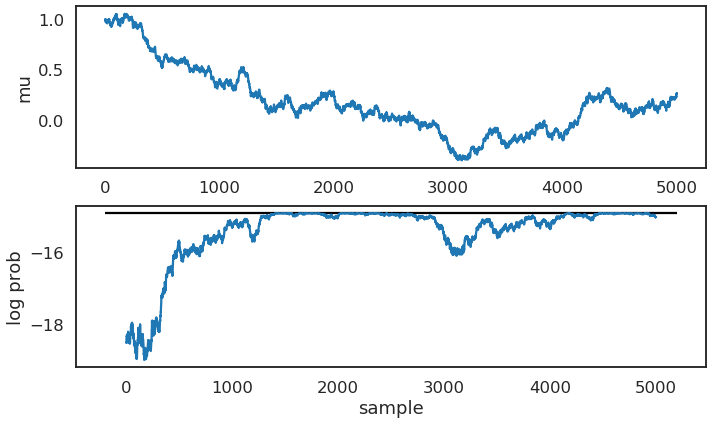

In [69]:
traceplot(posterior_small, ll_small)

In [ ]:
# moderate proposal width
posterior, ll = sampler(data, samples=5000, mu_init=.1, proposal_width=0.5)

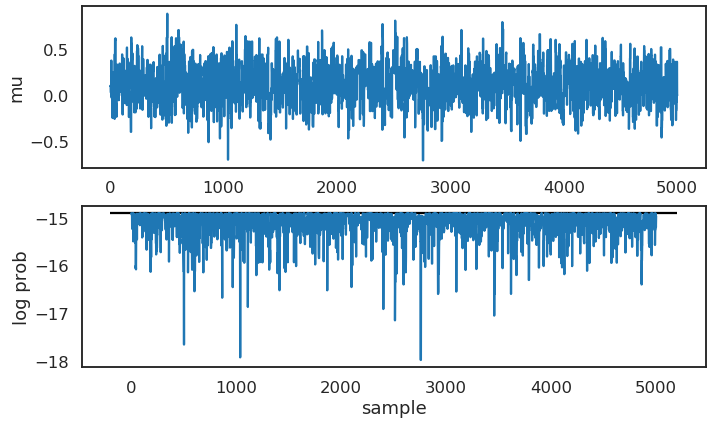

In [70]:
traceplot(posterior, ll)

In [63]:
# large proposal width 
posterior_large, ll_large = sampler(data, samples=5000, mu_init=1., proposal_width=3.)

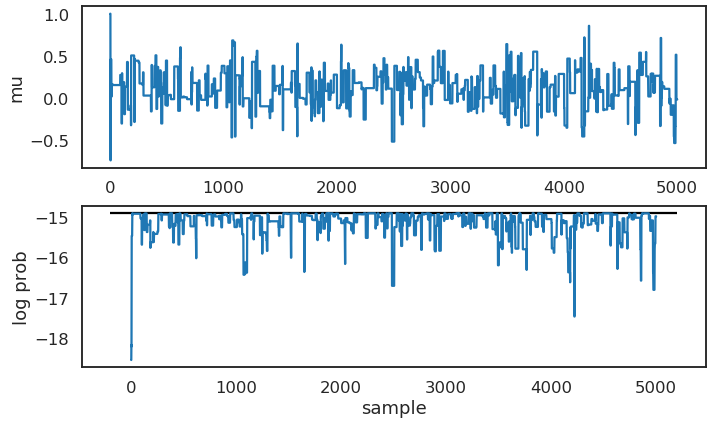

In [71]:
traceplot(posterior_large, ll_large)

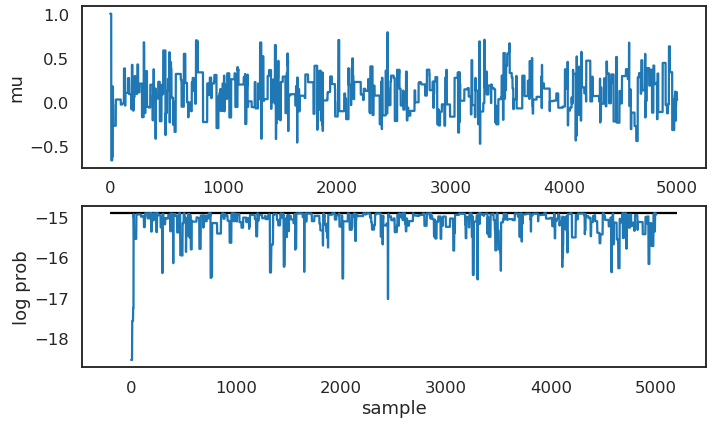

In [62]:
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(posterior_large); plt.ylabel('mu'); #plt.xlabel('sample'); 
plt.subplot(2, 1, 2)
plt.plot(np.log10(ll_large)); plt.xlabel('sample'); plt.ylabel('log prob');
plt.hlines(np.log10(p_true), -200, len(ll_large)+200)
plt.tight_layout()

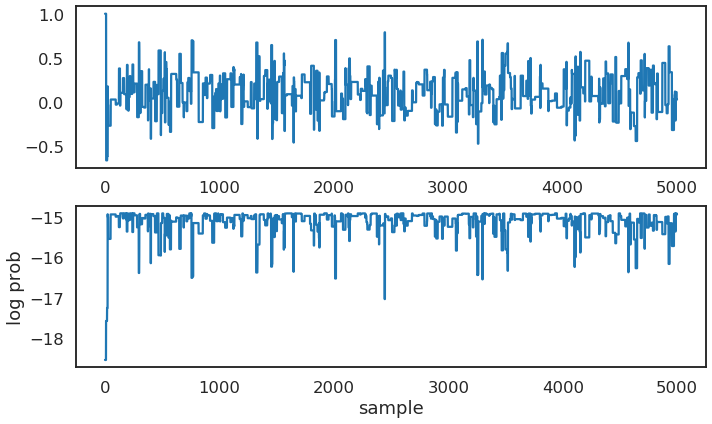

In [57]:
fig, ax = plt.subplots(2, 1, figsize = (10, 6))
ax[0].plot(posterior_large); plt.xlabel('sample'); plt.ylabel('mu');
ax[1].plot(np.log10(ll_large)); plt.xlabel('sample'); plt.ylabel('log prob');
plt.tight_layout()
#_ = ax.set(xlabel='sample', ylabel='mu');

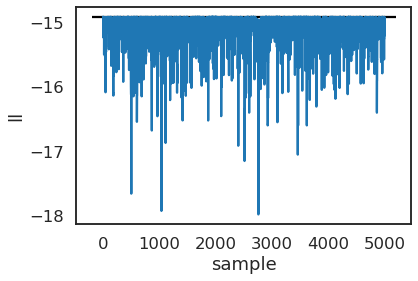

In [42]:
fig, ax = plt.subplots()
ax.hlines(np.log10(p_true), -200, len(ll_large)+200)
ax.plot(np.log10(ll)); plt.xlabel('sample'); plt.ylabel('ll');

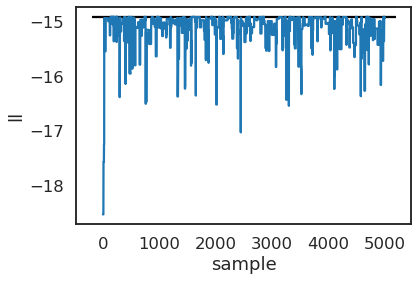

In [43]:
fig, ax = plt.subplots()
ax.hlines(np.log10(p_true), -200, len(ll_large)+200)
ax.plot(np.log10(ll_large)); plt.xlabel('sample'); plt.ylabel('ll');

两者进行比较

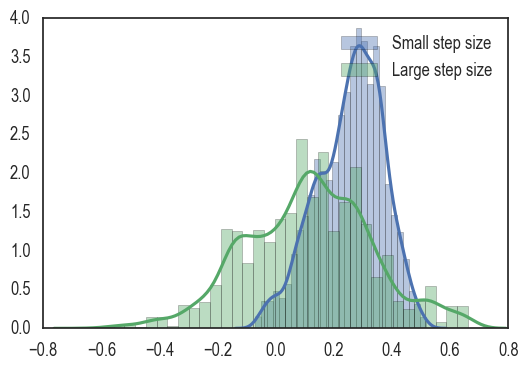

In [15]:
sns.distplot(posterior_small[1000:], label='Small step size')
sns.distplot(posterior_large[1000:], label='Large step size');
_ = plt.legend();

下面分析自相关系数

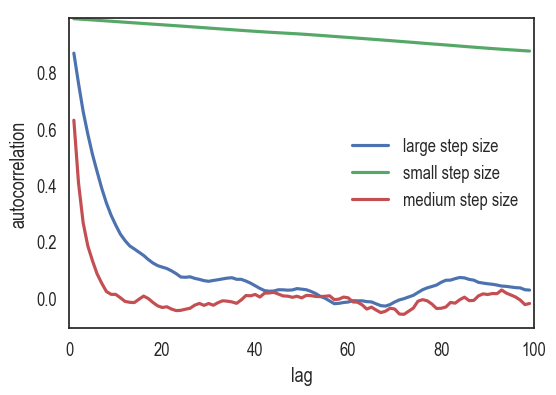

In [16]:
from pymc3.stats import autocorr
lags = np.arange(1, 100)
fig, ax = plt.subplots()
ax.plot(lags, [autocorr(posterior_large, l) for l in lags], label='large step size')
ax.plot(lags, [autocorr(posterior_small, l) for l in lags], label='small step size')
ax.plot(lags, [autocorr(posterior, l) for l in lags], label='medium step size')
ax.legend(loc=0)
_ = ax.set(xlabel='lag', ylabel='autocorrelation', ylim=(-.1, 1))

Python中的pymc3包可以很方便地进行MCMC采样。

100%|██████████| 15000/15000 [00:01<00:00, 14445.82it/s]


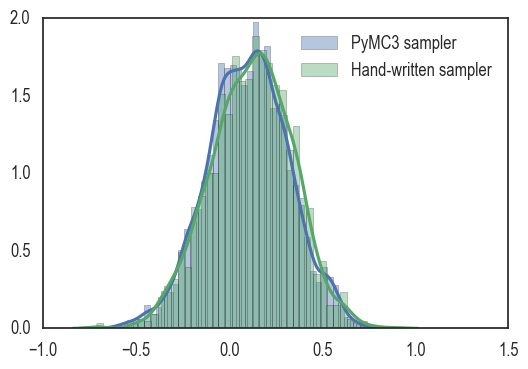

In [19]:
import pymc3 as pm

with pm.Model():
    mu = pm.Normal('mu', 0, 1)
    sigma = 1.
    returns = pm.Normal('returns', mu=mu, sd=sigma, observed=data)
    
    step = pm.Metropolis()
    trace = pm.sample(15000, step)
    
sns.distplot(trace[2000:]['mu'], label='PyMC3 sampler');
sns.distplot(posterior[500:], label='Hand-written sampler');
plt.legend();

## 参考文献
1. http://twiecki.github.io/blog/2015/11/10/mcmc-sampling/